In [2]:
import numpy as np 
import pandas as pd 
from data_processing import generate_vocab, process_data, create_dataloaders 
from model import get_pretrained_emb, EncoderDecoder, EncoderRNN, DecoderRNN, DecoderSimpleRNN, EncoderSimpleRNN, \
    Attention, DecoderAttnRNN, DecoderRNNV2
from train_eval import count_parameters, summarize_results, plot_single_learning_curve, load_experiment_log
from train_eval import train_and_eval_V3 #, tensor2corpus_V2
import importlib
import pickle as pkl 

In [13]:
# model identification
MODEL_NAME = 'zh-seq2seq-rnn-simple-context'
SRC_LANG = 'zh'
TARG_LANG = 'en'

# data processing params  
SRC_MAX_SENTENCE_LEN = 10
TARG_MAX_SENTENCE_LEN = 10
SRC_VOCAB_SIZE = 30000 #30000
TARG_VOCAB_SIZE = 30000 #30000

# model architecture params 
NUM_LAYERS = 2 #2 
ENC_HIDDEN_DIM = 300 
DEC_HIDDEN_DIM = ENC_HIDDEN_DIM #2 * ENC_HIDDEN_DIM 
TEACHER_FORCING_RATIO = 1
CLIP_GRAD_MAX_NORM = 1
ENC_DROPOUT = 0 # to actually implement
DEC_DROPOUT = 0 # to actually implement

# training params  
BATCH_SIZE = 8 #32
NUM_EPOCHS = 10
LR = 0.00025 # 0.0005
OPTIMIZER = 'Adam'
LAZY_TRAIN = False

In [4]:
# store as dict to save to results later 
params = {'model_name': MODEL_NAME, 'src_lang': SRC_LANG, 'targ_lang': TARG_LANG, 
          'src_max_sentence_len': SRC_MAX_SENTENCE_LEN, 'targ_max_sentence_len': TARG_MAX_SENTENCE_LEN, 
          'src_vocab_size': SRC_VOCAB_SIZE, 'targ_vocab_size': TARG_VOCAB_SIZE, 
          'num_layers': NUM_LAYERS, 'enc_hidden_dim': ENC_HIDDEN_DIM, 'dec_hidden_dim': DEC_HIDDEN_DIM,
          'teacher_forcing_ratio': TEACHER_FORCING_RATIO, 'clip_grad_max_norm': CLIP_GRAD_MAX_NORM,
          'enc_dropout': ENC_DROPOUT, 'dec_dropout': DEC_DROPOUT, 
          'batch_size': BATCH_SIZE, 'num_epochs': NUM_EPOCHS, 'learning_rate': LR, 'optimizer': OPTIMIZER, 
          'lazy_train': LAZY_TRAIN} 

In [5]:
# # takes a long time to process, save to pickle for reimport in future 
# vocab = generate_vocab(SRC_LANG, TARG_LANG, SRC_VOCAB_SIZE, TARG_VOCAB_SIZE)
# vocab_filename = "{}-{}-vocab.p".format(SRC_LANG, TARG_LANG)
# pkl.dump(vocab, open(vocab_filename, "wb"))

In [6]:
# reload from pickle 
vocab_filename = "{}-{}-vocab.p".format(SRC_LANG, TARG_LANG)
vocab = pkl.load(open(vocab_filename, "rb"))
data = process_data(SRC_LANG, TARG_LANG, vocab)
data_minibatch = process_data(SRC_LANG, TARG_LANG, vocab, sample_limit=BATCH_SIZE) 
data_minitrain = process_data(SRC_LANG, TARG_LANG, vocab, sample_limit=1000)

In [9]:
# create dataloaders 
loaders_full = create_dataloaders(data, SRC_MAX_SENTENCE_LEN, TARG_MAX_SENTENCE_LEN, BATCH_SIZE)
loaders_minibatch = create_dataloaders(data_minibatch, SRC_MAX_SENTENCE_LEN, TARG_MAX_SENTENCE_LEN, BATCH_SIZE)
loaders_minitrain = create_dataloaders(data_minitrain, SRC_MAX_SENTENCE_LEN, TARG_MAX_SENTENCE_LEN, BATCH_SIZE)

In [10]:
# define model 

# encoder = EncoderRNN(enc_hidden_dim=ENC_HIDDEN_DIM, num_layers=NUM_LAYERS, src_max_sentence_len=SRC_MAX_SENTENCE_LEN,
#                      pretrained_word2vec=get_pretrained_emb(vocab[SRC_LANG]['word2vec'], vocab[SRC_LANG]['token2id']))
encoder = EncoderSimpleRNN(enc_hidden_dim=ENC_HIDDEN_DIM, num_layers=NUM_LAYERS, src_max_sentence_len=SRC_MAX_SENTENCE_LEN,
                           pretrained_word2vec=get_pretrained_emb(vocab[SRC_LANG]['word2vec'], vocab[SRC_LANG]['token2id']))

decoder = DecoderRNNV2(dec_hidden_dim=DEC_HIDDEN_DIM, enc_hidden_dim=ENC_HIDDEN_DIM, num_layers=NUM_LAYERS, 
                       targ_vocab_size=TARG_VOCAB_SIZE, targ_max_sentence_len=TARG_MAX_SENTENCE_LEN, 
                       pretrained_word2vec=get_pretrained_emb(vocab[TARG_LANG]['word2vec'], vocab[TARG_LANG]['token2id']))
# decoder = DecoderSimpleRNN(dec_hidden_dim=DEC_HIDDEN_DIM, enc_hidden_dim=ENC_HIDDEN_DIM, num_layers=NUM_LAYERS, 
#                            targ_vocab_size=TARG_VOCAB_SIZE, targ_max_sentence_len=TARG_MAX_SENTENCE_LEN, 
#                            pretrained_word2vec=get_pretrained_emb(vocab[TARG_LANG]['word2vec'], vocab[TARG_LANG]['token2id']))
# decoder = DecoderAttnRNN(dec_hidden_dim=DEC_HIDDEN_DIM, enc_hidden_dim=ENC_HIDDEN_DIM, num_layers=NUM_LAYERS, 
#                          targ_vocab_size=TARG_VOCAB_SIZE, src_max_sentence_len=SRC_MAX_SENTENCE_LEN, 
#                          targ_max_sentence_len=TARG_MAX_SENTENCE_LEN, 
#                          pretrained_word2vec=get_pretrained_emb(vocab[TARG_LANG]['word2vec'], vocab[TARG_LANG]['token2id']))

model = EncoderDecoder(encoder, decoder, vocab[TARG_LANG]['token2id']) 

In [14]:
model, results = train_and_eval_V3(
    model=model, loaders_full=loaders_full, loaders_minibatch=loaders_minibatch, loaders_minitrain=loaders_minitrain, 
    params=params, vocab=vocab, print_intermediate=True, save_checkpoint=True, save_to_log=True, lazy_eval=True, inspect_samples=1)

Epoch: 0.00, Train Loss: 0.00, Val Loss: 6.28, Train BLEU: 0.00, Val BLEU: 0.42
Sampling from val predictions...
Source: 因此 我 觉得 太好了 这 是 我 的 责任 我
Reference: so i &apos;m like , &quot; cool . i
Model: <SOS> and the , , , , , , ,

Epoch: 0.07, Train Loss: 0.00, Val Loss: 6.06, Train BLEU: 0.00, Val BLEU: 1.69
Sampling from val predictions...
Source: 这些 光会 反射 射进 进入 房间 一些 会 返回 回到
Reference: it &apos;s going to bounce , go inside the
Model: <SOS> and is a a a of the of of

Epoch: 0.11, Train Loss: 0.00, Val Loss: 5.86, Train BLEU: 0.00, Val BLEU: 2.57
Sampling from val predictions...
Source: 然而 那时 他们 再 要 拿 回 这些 照片 所需
Reference: the time it took , however , to get
Model: <SOS> so the , the a the , , &apos;s

Epoch: 0.15, Train Loss: 0.00, Val Loss: 5.79, Train BLEU: 0.00, Val BLEU: 2.76
Sampling from val predictions...
Source: 我 的 新学 学校 现在 也 加入 进来 并 帮助
Reference: my new school now is coming in and helping
Model: <SOS> i i , , , the , , ,

Epoch: 0.19, Train Loss: 0.00, Val Loss: 5.67, Train 

Epoch: 1.30, Train Loss: 0.00, Val Loss: 4.86, Train BLEU: 0.00, Val BLEU: 5.22
Sampling from val predictions...
Source: 有 足够 的 空间 去 种植 <UNK> <UNK> 两千 两千五百
Reference: that &apos;s enough space to plant <UNK> million tomato
Model: <SOS> there &apos;s are to to to a the the

Epoch: 1.34, Train Loss: 0.00, Val Loss: 4.84, Train BLEU: 0.00, Val BLEU: 4.77
Sampling from val predictions...
Source: 开车 车行 行驶 在 加纳 的 一条 路上 与 free
Reference: driving down a road in ghana with partners of
Model: <SOS> and the the the , the , , ,

Epoch: 1.37, Train Loss: 0.00, Val Loss: 4.82, Train BLEU: 0.00, Val BLEU: 5.23
Sampling from val predictions...
Source: 我 在 加纳 地下 50 米 深 的 一个 非法
Reference: i &apos;m 150 feet down an illegal mine shaft
Model: <SOS> i i a in the the the of the

Epoch: 1.41, Train Loss: 0.00, Val Loss: 4.84, Train BLEU: 0.00, Val BLEU: 5.41
Sampling from val predictions...
Source: 所以 你 已经 拿到 了 这个 奖学 奖学金 richard <UNK>
Reference: so you got this scholarship . yep . <EOS>
Model: <SOS> so , you

Epoch: 2.52, Train Loss: 0.00, Val Loss: 4.65, Train BLEU: 0.00, Val BLEU: 5.90
Sampling from val predictions...
Source: 我 的 意思 是 一些 人 想 叫 他 为
Reference: i mean , some people wanted him to be
Model: <SOS> i mean , people of people , to ,

Epoch: 2.56, Train Loss: 0.00, Val Loss: 4.63, Train BLEU: 0.00, Val BLEU: 5.58
Sampling from val predictions...
Source: 在 这个 世界 上有 <UNK> <UNK> <UNK> <EOS> <PAD> <PAD>
Reference: so there &apos;s two types of <UNK> in this
Model: <SOS> in this this the in world the world .

Epoch: 2.60, Train Loss: 0.00, Val Loss: 4.63, Train BLEU: 0.00, Val BLEU: 5.37
Sampling from val predictions...
Source: 你 可以 想象 这个 小镇 肯定 备受 摧残 <EOS> <PAD>
Reference: as you can imagine , the town had been
Model: <SOS> you can can imagine that the . . .

Epoch: 2.64, Train Loss: 0.00, Val Loss: 4.65, Train BLEU: 0.00, Val BLEU: 5.12
Sampling from val predictions...
Source: 我 本 以为 只有 我们 意大利 意大利人 大利 利人 在
Reference: i thought it was only us italians <UNK> around
Model: <SOS> i i , we 

Epoch: 3.71, Train Loss: 0.00, Val Loss: 4.59, Train BLEU: 0.00, Val BLEU: 6.10
Sampling from val predictions...
Source: 我 想来 分享 几个 有用 的 方法 告诉 你们 如何
Reference: i want to share a few keys on how
Model: <SOS> i i to talk about a of about you

Epoch: 3.75, Train Loss: 0.00, Val Loss: 4.62, Train BLEU: 0.00, Val BLEU: 5.97
Sampling from val predictions...
Source: 你 的 下 一步 计划 是 什么 <EOS> <PAD> <PAD>
Reference: what &apos;s the next one on your list ?
Model: <SOS> what your your your ? ? ? ? ?

Epoch: 3.79, Train Loss: 0.00, Val Loss: 4.64, Train BLEU: 0.00, Val BLEU: 5.57
Sampling from val predictions...
Source: 今天 我 做到 了 <EOS> <PAD> <PAD> <PAD> <PAD> <PAD>
Reference: and here i am today . <EOS> <PAD> <PAD>
Model: <SOS> today i i i . <EOS> <EOS> <EOS> <EOS>

Epoch: 3.82, Train Loss: 0.00, Val Loss: 4.66, Train BLEU: 0.00, Val BLEU: 5.79
Sampling from val predictions...
Source: 有时 有时候 时候 路面 面会 出现 坑 槽 <EOS> <PAD>
Reference: sometimes you can create potholes with that . <EOS>
Model: <SOS> somet

Epoch: 4.94, Train Loss: 0.00, Val Loss: 4.62, Train BLEU: 0.00, Val BLEU: 6.11
Sampling from val predictions...
Source: 我 想要 人们 拿走 它 但是 同时 我 也 希望
Reference: i want them to take it , but at
Model: <SOS> i want to get to it , and i

Epoch: 4.97, Train Loss: 0.00, Val Loss: 4.64, Train BLEU: 0.00, Val BLEU: 5.98
Sampling from val predictions...
Source: 同时 我 在 考虑 如果 没有 途径 去 得到 健康
Reference: and i was wondering , how would you feel
Model: <SOS> and i i , , if i i be

Epoch: 5.00, Train Loss: 0.00, Val Loss: 4.63, Train BLEU: 0.00, Val BLEU: 5.98
Sampling from val predictions...
Source: 我 和 一个 温柔 <UNK> 善良 男人 再次 结婚 有
Reference: i <UNK> a kind and gentle man , and
Model: <SOS> and i a <UNK> <UNK> <UNK> a , and

Experiment completed in 256 minutes with 4.58 best validation loss and 6.61 best validation BLEU.


In [15]:
summarize_results(load_experiment_log())[['dt_created', 'num_epochs', 'learning_rate', 'clip_grad_max_norm', 'val_loss']].head()

,dt_created,num_epochs,learning_rate,clip_grad_max_norm,val_loss
20,2018-12-03 10:21:36,5,0.00025,1,4.584406
19,2018-12-03 01:28:34,200,0.00050,1,9.460873
18,2018-12-02 18:07:06,500,0.00050,10,9.337103
17,2018-12-02 18:01:56,500,0.00050,10,8.728790
16,2018-12-02 18:00:10,500,0.00050,10,9.198834


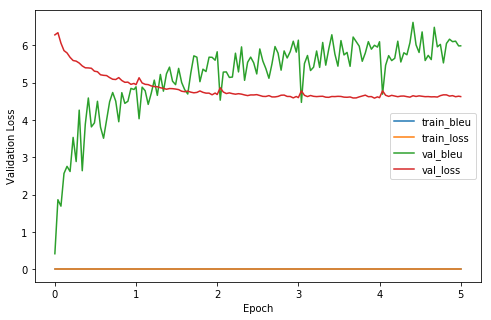

In [16]:
plot_single_learning_curve(results)